In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from PIL import Image

In [191]:
class ImageFolder(Dataset):
    REAL_FOLDERS = {'landscape', 'ffhq', 'metfaces', 'imagenet', 'coco', 'afhq', 'lsun', 'celebahq'}
    FAKE_FOLDERS = {
        'stylegan2', 'lama', 'stable_diffusion', 'face_synthetics', 'ddpm', 'gansformer',
        'cips', 'big_gan', 'projected_gan', 'star_gan', 'mat', 'vq_diffusion', 'stylegan1',
        'generative_inpainting', 'diffusion_gan', 'sfhq', 'stylegan3', 'denoising_diffusion_gan',
        'pro_gan', 'taming_transformer', 'gau_gan', 'latent_diffusion', 'palette', 'glide', 'cycle_gan'
    }

    def __init__(self, root_dir, metadata_name='metadata.csv', nrows=None, transform=None, balance=True, random_state=42):
        self.root_dir = Path(root_dir)
        self.metadata_name = metadata_name
        self.transform = transform
        self.balance = balance
        self.random_state = random_state

        # Carica campioni reali e fake
        real_samples = self._load_samples(self.REAL_FOLDERS, label='real')
        fake_samples = self._load_samples(self.FAKE_FOLDERS, label_by_folder=True, nrows=nrows)

        samples = real_samples + fake_samples

        # Bilanciamento opzionale tra real e fake (tutte le fake vengono trattate come unico gruppo)
        if self.balance:
            samples = self._balance_binary(samples)

        samples = [(path, label) for path, label in samples if label == 'real']

        self.samples = samples + fake_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(self.root_dir / img_path).convert('RGB')
        return (self.transform(image) if self.transform else image), label

    def _load_samples(self, folders, label_by_folder=False, nrows=None, label='fake'):
        samples = []
        for folder in folders:
            meta_file = self.root_dir / folder / self.metadata_name
            if not meta_file.exists():
                continue

            df = pd.read_csv(meta_file)
            # Per fake folders, filtra eventuali target=0
            if folder in self.FAKE_FOLDERS and 'target' in df.columns:
                df = df[df['target'] > 0]

            if nrows:
                df = df.head(nrows)

            # Imposta label: se label_by_folder=True, usa il nome della cartella, altrimenti label generica
            use_label = folder if label_by_folder else label

            for rel_path in df['image_path'].tolist():
                samples.append((Path(folder) / Path(rel_path).as_posix(), use_label))

        return samples

    def _balance_binary(self, samples):
        # Ribilancia in due classi: 'real' vs 'fake' (qualsiasi label != 'real' trattata come fake)
        X = [[str(path)] for path, _ in samples]
        y = ['real' if label == 'real' else 'fake' for _, label in samples]

        rus = RandomUnderSampler(random_state=self.random_state)
        X_res, y_res = rus.fit_resample(X, y)

        # Riporta label originali per real e fake generico
        return [(Path(x[0]), lab) for x, lab in zip(X_res, y_res)]


In [192]:
def train_SVM(dataset: pd.DataFrame, test_size = 0.4):
    # Otteniamo X e y dal daframe bilanciato
    X = dataset.drop(columns='label').values
    y = dataset['label'].values

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Modello e griglia di ricerca per la cross-validation
    svc = SVC()
    param_grid = [
        {'kernel': ['linear'],  'C': [0.1, 1, 10]},
        {'kernel': ['rbf'],     'C': [1, 10],      'gamma': ['scale', 0.1]},
        {'kernel': ['sigmoid'], 'C': [1, 10],      'gamma': ['scale', 0.1], 'coef0': [0.0, 0.1, 0.5]}
    ]

    grid = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    # Risultati
    print(f"Best params: {grid.best_params_}")

    prediction = grid.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    print(f'The accuracy of the SVM is: {accuracy}')
    print(f'Classification Report:\n{classification_report(y_test, prediction)}')
    cf = confusion_matrix(y_test, prediction)
    print(f'Confusion Matrix:\n {cf}')
    plot_confusion_matrix(cf, dataset)


def plot_confusion_matrix(cf, df: pd.DataFrame):
    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nClasse immagine predetta')
    ax.set_ylabel('Classe reale immagine ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(df['label'].unique())
    ax.yaxis.set_ticklabels(df['label'].unique())

    ## Display the visualization of the Confusion Matrix.
    plt.show()

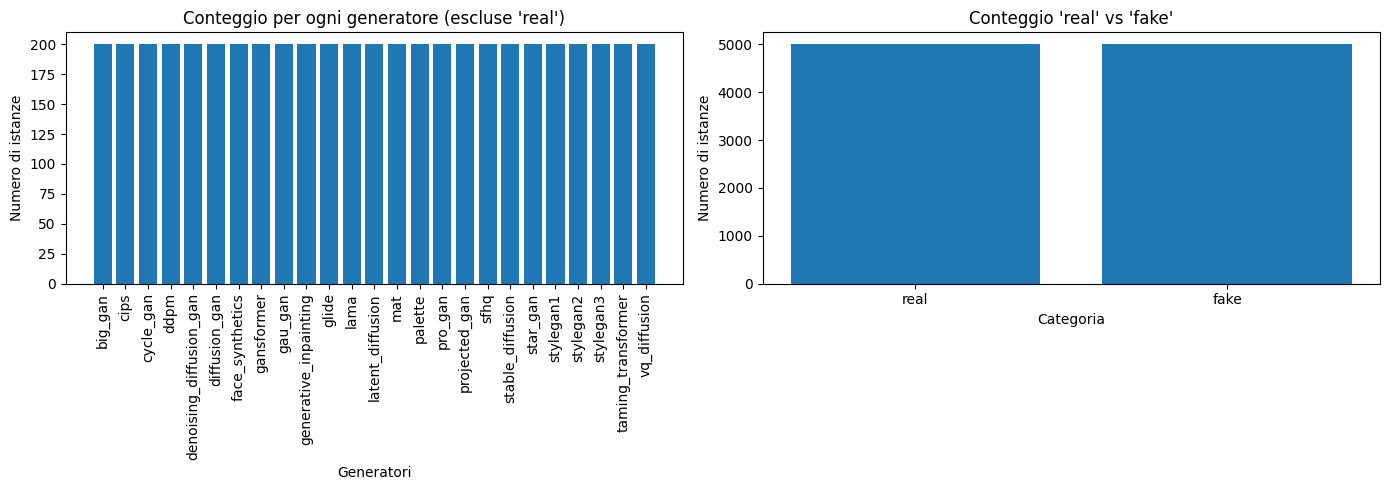

In [193]:
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

dataset = ImageFolder(root_dir='./artifact', nrows=200, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
data = pd.DataFrame(dataset.samples, columns=['path', 'label'])

# --- Primo istogramma: conteggio di ogni label diversa da 'real' ---
df_excl = data[data['label'] != 'real']
counts_excl = df_excl['label'].value_counts().sort_index()  # sort_index per ordine alfabetico

# --- Secondo istogramma: binarizzazione in 'real' vs 'fake' ---
binary = data['label'].apply(lambda x: 'real' if x == 'real' else 'fake')
counts_bin = binary.value_counts().loc[['real','fake']]     # ordine garantito

# --- Disegna i due plot affiancati ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot delle label (escluse 'real')
axes[0].bar(counts_excl.index, counts_excl.values)
axes[0].set_title("Conteggio per ogni generatore (escluse 'real')")
axes[0].set_xlabel("Generatori")
axes[0].set_ylabel("Numero di istanze")
axes[0].tick_params(axis='x', rotation=90)

# Bar plot binario real vs fake
axes[1].bar(counts_bin.index, counts_bin.values)
axes[1].set_title("Conteggio 'real' vs 'fake'")
axes[1].set_xlabel("Categoria")
axes[1].set_ylabel("Numero di istanze")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# carica ViT-B/16 pretrained da torchvision
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# rimuove la testa di classificazione
model.heads.head = nn.Identity()
model.eval().to(device)

all_feats = []
all_labels = []
all_paths = []

with torch.no_grad():
    for imgs, labs in loader:
        imgs = imgs.to(device)
        feats = model(imgs)
        all_feats.append(feats.cpu().numpy())
        all_labels.extend(labs)

# prepara DataFrame
features = np.vstack(all_feats)
labels = np.array(all_labels)

feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df = pd.DataFrame(features, columns=feat_cols)
df['label'] = labels
df['label'] = df['label'].apply(lambda x: 'real' if x == 'real' else 'fake')

df.groupby('label').size()

label
fake    5000
real    5000
dtype: int64

In [195]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,label
0,0.415095,0.048932,-1.160616,0.183989,0.812332,-0.364700,0.126208,-0.332685,-0.584357,-0.523727,...,0.688320,-0.513961,-0.120789,-0.370117,0.118298,0.731246,0.268578,0.209655,-0.358871,real
1,-0.587211,0.039722,0.322494,0.393859,0.406070,-0.091227,0.658843,0.406679,-0.298155,-0.021668,...,0.246549,0.207003,-0.719292,0.023538,-0.957637,0.546380,0.185108,-0.901143,-0.503215,real
2,-0.420894,-0.777860,-0.473015,0.417358,-0.052592,-0.532017,0.339313,-0.026159,-0.688262,-0.462966,...,-0.508050,0.227198,-0.439395,-0.335858,-0.631315,-0.290345,0.151410,0.426333,-0.431879,real
3,-0.052548,-0.424844,-0.567480,0.268386,-0.413790,0.054111,0.456531,-0.899809,-0.253795,-1.027933,...,-0.187396,0.978135,-0.117288,0.317280,-1.187299,0.603771,-0.024408,0.150151,-0.533019,real
4,0.981738,-0.631078,-0.897980,-0.185009,-0.103464,-0.580569,0.565228,-0.400025,0.301390,-0.269238,...,0.212598,0.467951,-0.892823,0.138176,-1.341113,-0.218642,-0.355871,0.494202,-0.984469,real


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.8215
Classification Report:
              precision    recall  f1-score   support

        fake       0.81      0.82      0.82      1942
        real       0.83      0.82      0.83      2058

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000

Confusion Matrix:
 [[1598  344]
 [ 370 1688]]


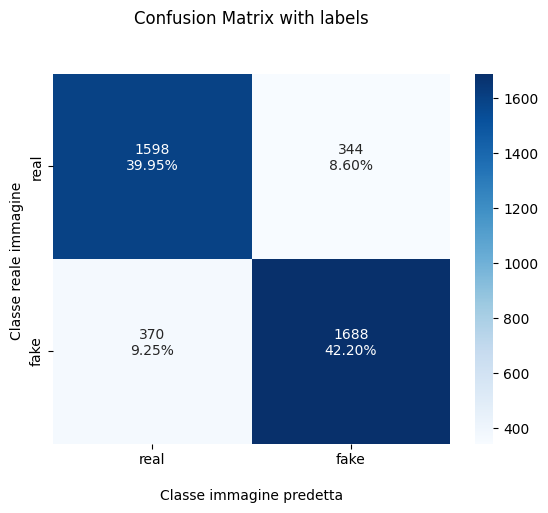

In [196]:
train_SVM(df)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.8293333333333334
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.82      0.82      1463
        real       0.83      0.84      0.83      1537

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

Confusion Matrix:
 [[1203  260]
 [ 252 1285]]


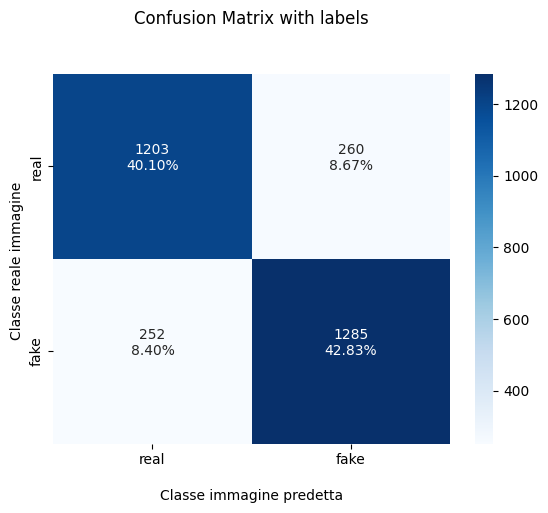

In [203]:
train_SVM(df, test_size=0.3)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.84
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.84      0.84       988
        real       0.85      0.84      0.84      1012

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Confusion Matrix:
 [[834 154]
 [166 846]]


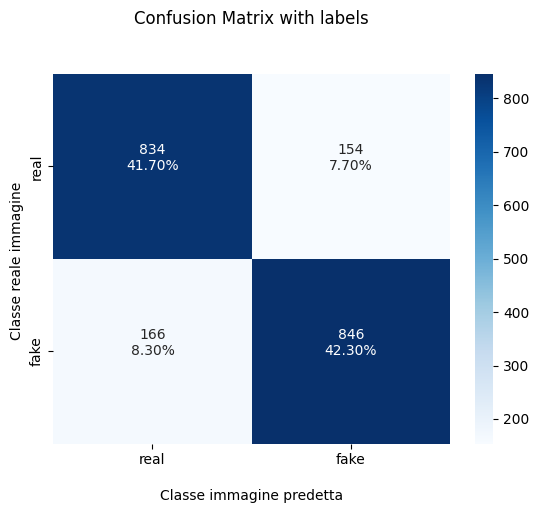

In [202]:
train_SVM(df, test_size=0.2)

# Riduzione del numero delle features

In [198]:
feat_cols = [c for c in df.columns if c.startswith('feat_')]
X = df[feat_cols].values

pca_full = PCA().fit(X)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumvar >= 0.95) + 1
print(f"Numero di componenti per 95% varianza: {n_components}")

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

pca_cols = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)

label_col = 'label'
df_labels = df[[label_col]]

df_reduced = pd.concat([df_labels, df_pca], axis=1)

print("Shape originale:", df.shape)
print("Shape ridotto:", df_reduced.shape)
df_reduced.head()

Numero di componenti per 95% varianza: 539
Shape originale: (10000, 769)
Shape ridotto: (10000, 540)


,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC530,PC531,PC532,PC533,PC534,PC535,PC536,PC537,PC538,PC539
0,real,4.452354,3.978933,-5.100599,-2.845080,2.393063,-3.378103,-0.478175,-1.164739,0.506738,...,0.221882,-0.021428,0.238291,0.069487,0.048895,-0.128180,-0.150365,0.160290,-0.001368,0.142459
1,real,3.355122,1.340310,7.552821,-2.955248,-0.087137,-1.808826,-1.844605,-0.072198,0.739899,...,0.023672,-0.487108,0.750218,0.116960,-0.112095,0.171651,0.461197,-0.026801,0.350918,0.283016
2,real,2.668023,-1.267077,-0.466516,5.855372,-3.587316,-5.536855,-1.771551,1.483594,-0.750182,...,-0.253152,0.032078,0.265634,0.094457,-0.148960,0.070609,-0.024995,-0.302863,0.341082,-0.154679
3,real,1.095603,-2.496210,0.118950,8.119945,-3.602722,-6.295508,-2.707063,2.054513,-2.793349,...,-0.472182,-0.000510,0.272494,-0.066684,0.334183,-0.409192,0.287666,0.386480,0.632607,-0.387555
4,real,1.975390,-1.842172,-0.066451,8.059998,-3.586017,-6.746128,-2.492060,1.878367,-1.626043,...,0.267808,0.523695,-0.086625,-0.460583,-0.345682,-0.111448,0.083296,0.441894,0.089414,-0.163826


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.82
Classification Report:
              precision    recall  f1-score   support

        fake       0.81      0.82      0.82      1942
        real       0.83      0.82      0.82      2058

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000

Confusion Matrix:
 [[1599  343]
 [ 377 1681]]


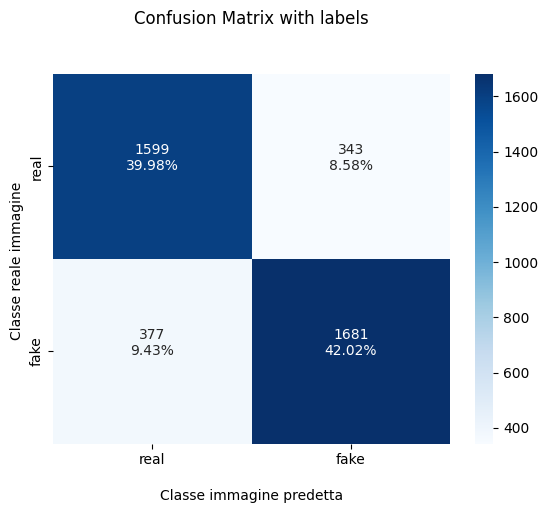

In [199]:
train_SVM(df_reduced)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.8276666666666667
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.82      0.82      1463
        real       0.83      0.84      0.83      1537

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

Confusion Matrix:
 [[1199  264]
 [ 253 1284]]


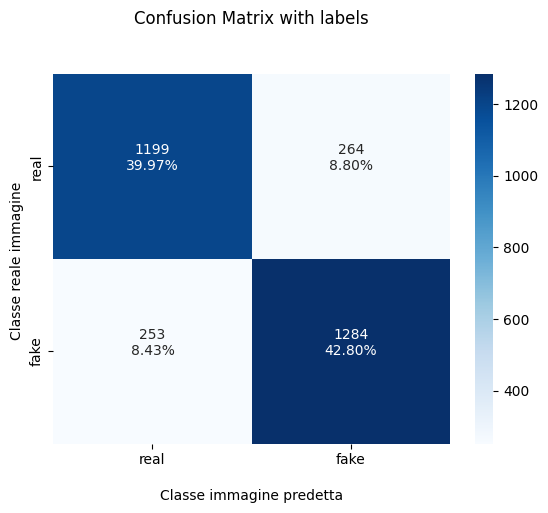

In [204]:
train_SVM(df_reduced, test_size=0.3)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy of the SVM is: 0.831
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.82      0.83       988
        real       0.83      0.84      0.83      1012

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Confusion Matrix:
 [[815 173]
 [165 847]]


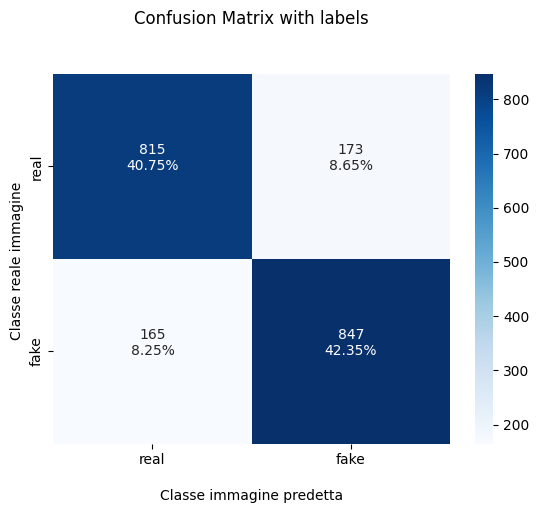

In [201]:
train_SVM(df_reduced, test_size=0.2)